In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from piecewise import InverseModel
import utlis

In [3]:
import sys
PATH_TO_ROOT = 'C:\\Users\\kushs\\Downloads\\Electricity usage prediction\\Electricity usage prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    
    return '{}/results/fig/linear_model/{}'.format(PATH_TO_ROOT, fig_name)

def generate_raw_data_path(data_name):
    
    return '{}/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

In [5]:
def add_holiday_weekend(data):
    
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    cal = calendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['Holiday'] = data.index.isin(holidays)

    data['Weekend'] = data.index.weekday > 4
    
    data['Non-workDay'] = data['Holiday'] | data['Weekend']
    data['Day Type'] = data['Non-workDay'].apply(lambda x : 'Non-Working Day' if x else 'Working Day')

    return data

## generate daily data

In [6]:
def HCD_cal(data, Tbase_H=[14, 16, 18, 20], Tbase_C=[8, 10, 12, 14]):
    columns = data.columns.values.tolist()
    for t_base_h in Tbase_H:
        data[f'HDH_{t_base_h}'] = data.apply(lambda row: max(0, t_base_h - row['Temperature']), axis=1)
    for t_base_c in Tbase_C:
        data[f'CDH_{t_base_c}'] = data.apply(lambda row: max(0, row['Temperature'] - t_base_c), axis=1)
    data.drop(columns, axis=1, inplace=True)
    return data

In [7]:
Th_base = range(5,25)
Tc_base = range(5,30)

for region in ['mum', 'hyd', 'delhi']:

    wea = pd.read_csv(generate_raw_data_path(f'weather/{region}_weather'), index_col=0)   
    wea.index = pd.to_datetime(wea.index) 
    wea_daily = pd.DataFrame({
        'Temperature, daily mean (degC)': wea['Temperature'].resample('D').mean(),
        'Temperature, daily peak (degC)': wea['Temperature'].resample('D').max(),
    })
    HCDH= HCD_cal(wea, Th_base, Tc_base)
    HCDH_daily = HCDH.resample('D').sum()
    wea_daily = pd.merge(wea_daily, HCDH_daily, left_index=True, right_index=True)
    
    ele = pd.read_csv(generate_raw_data_path(f'power/{region}_load'), index_col=0)
    ele.index = pd.to_datetime(ele.index)
    ele_daily_total = ele.resample('D').sum()/1000
    ele_daily_total.columns = ['Electricity demand, daily sum, (GWh)']
    ele_daily_peak = ele.resample('D').max()/1000
    ele_daily_peak.columns = ['Electricity power, daily peak, (GW)']
    ele_daily = pd.merge(ele_daily_total, ele_daily_peak, left_index=True, right_index=True)

    
    ele_daily = ele_daily.truncate(before='2015-07-02', after='2020-09-25')  
    data_daily = pd.merge(ele_daily, wea_daily, right_index=True, left_index=True)
    data_daily = add_holiday_weekend(data_daily)
    data_daily.to_csv(generate_result_data_path(f'{region}_daily'))

In [8]:
mum = pd.read_csv(generate_result_data_path('mum_daily'),index_col=0)
mum[mum['Electricity demand, daily sum, (GWh)']<50]

,"Electricity demand, daily sum, (GWh)","Electricity power, daily peak, (GW)","Temperature, daily mean (degC)","Temperature, daily peak (degC)",HDH_5,HDH_6,HDH_7,HDH_8,HDH_9,HDH_10,...,CDH_24,CDH_25,CDH_26,CDH_27,CDH_28,CDH_29,Holiday,Weekend,Non-workDay,Day Type
2019-11-03,2.513,2.513,17.062500,27.2,0.0,0.0,0.0,0.2,1.3,4.5,...,10.4,5.6,2.0,0.2,0.0,0.0,False,True,True,Non-Working Day
2020-03-08,7.274,2.573,12.917391,17.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,True,True,Non-Working Day


In [9]:
mum = mum[mum['Electricity demand, daily sum, (GWh)']>50]
mum.to_csv(generate_result_data_path(f'mum_daily'))

## Read data

In [10]:
mum = pd.read_csv(generate_result_data_path('mum_daily'),index_col=0)
mum.index = pd.to_datetime(mum.index)

hyd = pd.read_csv(generate_result_data_path('hyd_daily'),index_col=0)
hyd.index = pd.to_datetime(hyd.index)

delhi = pd.read_csv(generate_result_data_path('delhi_daily'),index_col=0)
delhi.index = pd.to_datetime(delhi.index)


## 5P model

In [11]:
def piecewise_linear(x, base, hcp, hsl, ccp, csl):
    
    if np.isnan(hcp) and np.isnan(hsl):
        hcp = ccp
        hsl = 0
    if np.isnan(csl) and np.isnan(csl):
        ccp = hcp
        csl = 0

    conds = [x < hcp, (x >= hcp) & (x <= ccp), x > ccp]

    funcs = [lambda x: hsl * x + base - hsl * hcp,
             lambda x: base,
             lambda x: csl * x + base - csl * ccp]

    return np.piecewise(x, conds, funcs)


def fiveP_analysis(data, plot_var):
    data = data[['Temperature, daily mean (degC)', plot_var, 'Day Type']]
    data.rename(columns={'Temperature, daily mean (degC)':'temp', plot_var:'value'}, inplace=True)
    
    data_wd = data[data['Day Type']=='Working Day']
    data_nwd = data[data['Day Type']=='Non-Working Day']
    
    model_wd = InverseModel(data_wd['temp'].values, data_wd['value'].values, plot_var)
    model_wd.fit_model()
    
    model_nwd = InverseModel(data_nwd['temp'].values, data_nwd['value'].values, plot_var)
    model_nwd.fit_model()
    
    temp_min = data['temp'].min()
    temp_max = data['temp'].max()
    temp_plot = np.linspace(temp_min,temp_max,100)
    load_wd_plot = piecewise_linear(temp_plot, *model_wd.model_p)
    load_nwd_plot = piecewise_linear(temp_plot, *model_nwd.model_p)
    
    resultForPlot = {'data_wd':data_wd, 'data_nwd':data_nwd, 'temp_plot':temp_plot,
                     'load_wd_plot':load_wd_plot, 'load_nwd_plot':load_nwd_plot}
    result_wd = model_wd.model_p.tolist() + [model_wd.rmse(), model_wd.R_Squared(adjusted_r2_calc=True)]
    result_nwd = model_nwd.model_p.tolist() + [model_nwd.rmse(), model_nwd.R_Squared(adjusted_r2_calc=True)]
    results = pd.DataFrame(data={'WD':result_wd, 'NWD':result_nwd},
                           index=['Base Load',
                                  'Heating Base Temp','Heating Slope',
                                  'Cooling Base Temp','Cooling Slope',
                                  'RMSE', 'R-squared'])
    
    return resultForPlot, results

In [12]:
mum_resultForPlot_5p, mum_results_5p = fiveP_analysis(mum, "Electricity demand, daily sum, (GWh)")
hyd_resultForPlot_5p, hyd_results_5p = fiveP_analysis(hyd, "Electricity demand, daily sum, (GWh)")
delhi_resultForPlot_5p, delhi_results_5p = fiveP_analysis(delhi, "Electricity demand, daily sum, (GWh)")

C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\1327416003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Temperature, daily mean (degC)':'temp', plot_var:'value'}, inplace=True)
C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\1327416003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Temperature, daily mean (degC)':'temp', plot_var:'value'}, inplace=True)
C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\1327416003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

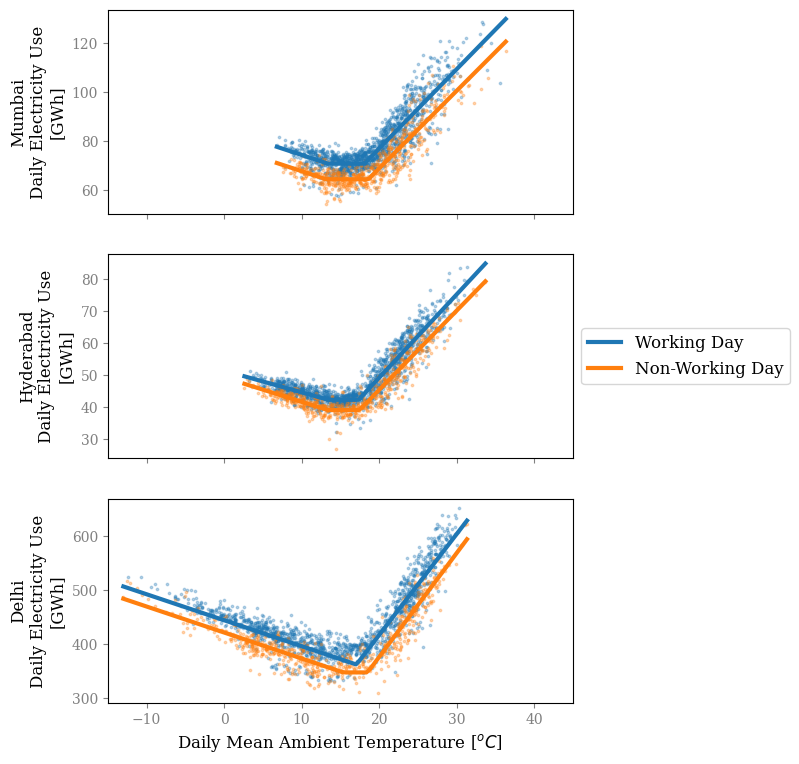

In [13]:
resultForPlot_all = [mum_resultForPlot_5p, hyd_resultForPlot_5p, delhi_resultForPlot_5p]
cities = ['Mumbai', 'Hyderabad', 'Delhi']

fig, axes = plt.subplots(3, 1, figsize = (6, 9), sharex=True)

for index in range(3):
    resultForPlot = resultForPlot_all[index]
    axes[index].scatter(resultForPlot['data_wd']['temp'].values, resultForPlot['data_wd']['value'].values, 
                color=default_colors[0], alpha=0.3, s=3)
    axes[index].plot(resultForPlot['temp_plot'], resultForPlot['load_wd_plot'], 
                 color=default_colors[0], lw=3, label='Working Day')
    axes[index].scatter(resultForPlot['data_nwd']['temp'].values, resultForPlot['data_nwd']['value'].values, 
                    color=default_colors[1], alpha=0.3, s=3)
    axes[index].plot(resultForPlot['temp_plot'], resultForPlot['load_nwd_plot'],
                 color=default_colors[1], lw=3, label='Non-Working Day')
    axes[index].set_ylabel(f'{cities[index]}\nDaily Electricity Use\n[GWh]')

axes[2].set_xlim(-15, 45)
axes[2].set_xlabel('Daily Mean Ambient Temperature [$^oC$]')

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.savefig(generate_fig_path('Figure 9'))

In [14]:
fiveP_result = pd.concat([mum_results_5p.T, hyd_results_5p.T, delhi_results_5p.T], keys=cities)

fiveP_result.round(2).to_csv(generate_result_data_path('Table 1'))

## HCDH model

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import math

In [16]:
def HDCH_analysis(data, plot_var):
    
    R_sq_wd = {}
    RMSE_wd ={}
    R_sq_nwd = {}
    RMSE_nwd ={}
    data_wd = data[data['Day Type']=='Working Day']
    data_nwd = data[data['Day Type']=='Non-Working Day']
    
    for temp_h in Th_base:
        r_h_wd = []
        mse_h_wd = []
        r_h_nwd = []
        mse_h_nwd = []
        for temp_c in Tc_base:
            # prepare data
            X_wd = data_wd[[f'HDH_{temp_h}',f'CDH_{temp_c}']].values
            y_wd = data_wd[plot_var].values
            X_nwd = data_nwd[[f'HDH_{temp_h}',f'CDH_{temp_c}']].values
            y_nwd = data_nwd[plot_var].values
            # fit model
            model_wd = LinearRegression()
            model_wd.fit(X_wd,y_wd)
            model_nwd = LinearRegression()
            model_nwd.fit(X_nwd,y_nwd)
            # r_square
            r_sq_wd = model_wd.score(X_wd,y_wd)
            r_h_wd.append(r_sq_wd)
            r_sq_nwd = model_nwd.score(X_nwd,y_nwd)
            r_h_nwd.append(r_sq_nwd)
            # rmse
            y_hat_wd = model_wd.predict(X_wd)
            mse_wd = mean_squared_error(y_wd,y_hat_wd)
            rmse_wd = math.sqrt(mse_wd)
            mse_h_wd.append(rmse_wd)
            y_hat_nwd = model_nwd.predict(X_nwd)
            mse_nwd = mean_squared_error(y_nwd,y_hat_nwd)
            rmse_nwd = math.sqrt(mse_nwd)
            mse_h_nwd.append(rmse_nwd)
        R_sq_wd[temp_h] = r_h_wd
        RMSE_wd[temp_h] = mse_h_wd
        R_sq_nwd[temp_h] = r_h_nwd
        RMSE_nwd[temp_h] = mse_h_nwd
        
    R_sq_wd_df = pd.DataFrame.from_dict(R_sq_wd, orient='index',columns=Tc_base)
    RMSE_wd_df = pd.DataFrame.from_dict(RMSE_wd, orient='index',columns=Tc_base)
    
    R_sq_nwd_df = pd.DataFrame.from_dict(R_sq_nwd, orient='index',columns=Tc_base)
    RMSE_nwd_df = pd.DataFrame.from_dict(RMSE_nwd, orient='index',columns=Tc_base)
    
    return R_sq_wd_df, RMSE_wd_df, R_sq_nwd_df, RMSE_nwd_df

In [17]:
plot_var = 'Electricity demand, daily sum, (GWh)'

R_sq_wd_mum, RMSE_wd_mum, R_sq_nwd_mum, RMSE_nwd_mum = HDCH_analysis(mum, plot_var)
R_sq_wd_hyd, RMSE_wd_hyd, R_sq_nwd_hyd, RMSE_nwd_hyd = HDCH_analysis(hyd, plot_var)
R_sq_wd_delhi, RMSE_wd_delhi, R_sq_nwd_delhi, RMSE_nwd_delhi = HDCH_analysis(delhi, plot_var)

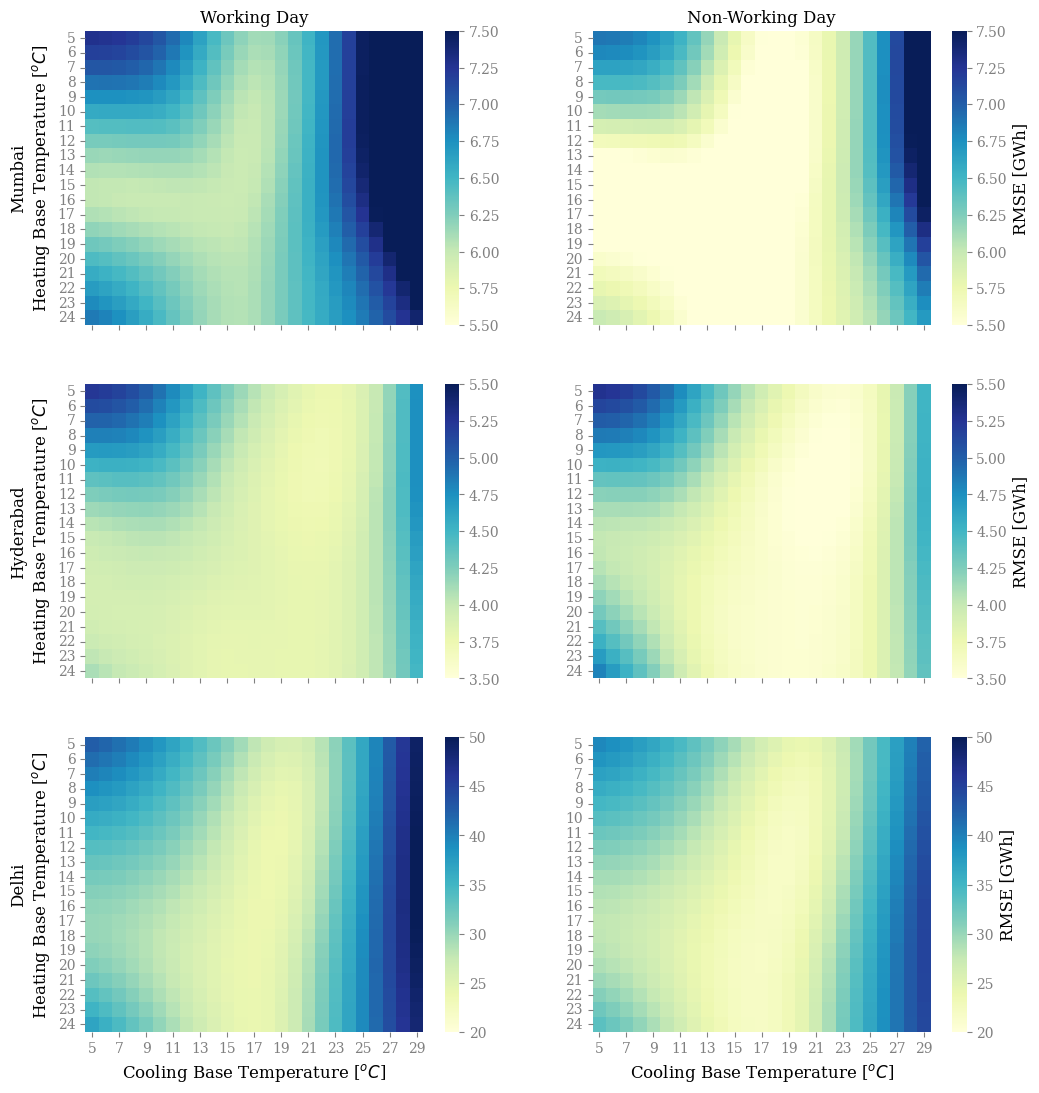

In [18]:
resultForPlot_all = [(RMSE_wd_mum, RMSE_nwd_mum), (RMSE_wd_hyd, RMSE_nwd_hyd), (RMSE_wd_delhi, RMSE_nwd_delhi)]
cities = ['Mumbai', 'Hyderabad', 'Delhi']
cbar_lim_all = [(5.5,7.5), (3.5, 5.5), (20, 50)]

fig, axes = plt.subplots(3, 2, figsize = (12, 13), sharex=True)

for index in range (3):
    RMSE_wd, RMSE_nwd = resultForPlot_all[index]
    city = cities[index]
    cbar_lim = cbar_lim_all[index]
    sns.heatmap(RMSE_wd, ax=axes[index,0], cmap="YlGnBu", xticklabels=2, vmin=cbar_lim[0], vmax=cbar_lim[1])
    sns.heatmap(RMSE_nwd, ax=axes[index,1], cmap="YlGnBu", xticklabels=2, vmin=cbar_lim[0], vmax=cbar_lim[1],
                cbar_kws={"label": "RMSE [GWh]"})
    axes[index, 0].set_ylabel(f'{city}\nHeating Base Temperature [$^oC$]')
axes[2, 0].set_xlabel('Cooling Base Temperature [$^oC$]')
axes[2, 1].set_xlabel('Cooling Base Temperature [$^oC$]')

axes[0, 0].set_title('Working Day')
axes[0, 1].set_title('Non-Working Day')

plt.savefig(generate_fig_path('Figure 10'))

In [19]:
def HCDH_coefficient(RMSE_df, data_df, plot_var):
    result = pd.DataFrame()
    heatBaseTemp = RMSE_df.index[np.where(RMSE_df == RMSE_df.values.min())[0][0]]
    coolBaseTemp = RMSE_df.columns[np.where(RMSE_df == RMSE_df.values.min())[1][0]]
    X = data_df[[f'HDH_{heatBaseTemp}',f'CDH_{coolBaseTemp}']].values
    y = data_df[plot_var].values
    model = LinearRegression()
    model.fit(X, y)
    result['Base Load'] = [model.intercept_]
    result['Heating Base Temp'] = [heatBaseTemp]
    result['Heating Slope'] = [model.coef_[0]]
    result['Cooling Base Temp'] = [coolBaseTemp]
    result['Cooling Slope'] = [model.coef_[1]]
    result['RMSE'] = [RMSE_df.values.min()]
    result['R-squared'] = [model.score(X, y)]
    return result

In [20]:
plot_var = 'Electricity demand, daily sum, (GWh)'
mum_results_hcdh_wd = HCDH_coefficient(RMSE_wd_mum, mum[mum['Day Type']=='Working Day'], plot_var)
mum_results_hcdh_nwd = HCDH_coefficient(RMSE_nwd_mum, mum[mum['Day Type']=='Non-Working Day'], plot_var)
mum_results_hcdh = pd.concat([mum_results_hcdh_wd, mum_results_hcdh_nwd])
mum_results_hcdh.index = ['WD', 'NWD']

hyd_results_hcdh_wd = HCDH_coefficient(RMSE_wd_hyd, hyd[hyd['Day Type']=='Working Day'], plot_var)
hyd_results_hcdh_nwd = HCDH_coefficient(RMSE_nwd_hyd, hyd[hyd['Day Type']=='Non-Working Day'], plot_var)
hyd_results_hcdh = pd.concat([hyd_results_hcdh_wd, hyd_results_hcdh_nwd])
hyd_results_hcdh.index = ['WD', 'NWD']

delhi_results_hcdh_wd = HCDH_coefficient(RMSE_wd_delhi, delhi[delhi['Day Type']=='Working Day'], plot_var)
delhi_results_hcdh_nwd = HCDH_coefficient(RMSE_nwd_delhi, delhi[delhi['Day Type']=='Non-Working Day'], plot_var)
delhi_results_hcdh = pd.concat([delhi_results_hcdh_wd, delhi_results_hcdh_nwd])
delhi_results_hcdh.index = ['WD', 'NWD']

hcdh_result = pd.concat([mum_results_hcdh, hyd_results_hcdh, delhi_results_hcdh], keys=cities)
hcdh_result.round(2).to_csv(generate_result_data_path('Table 2'))

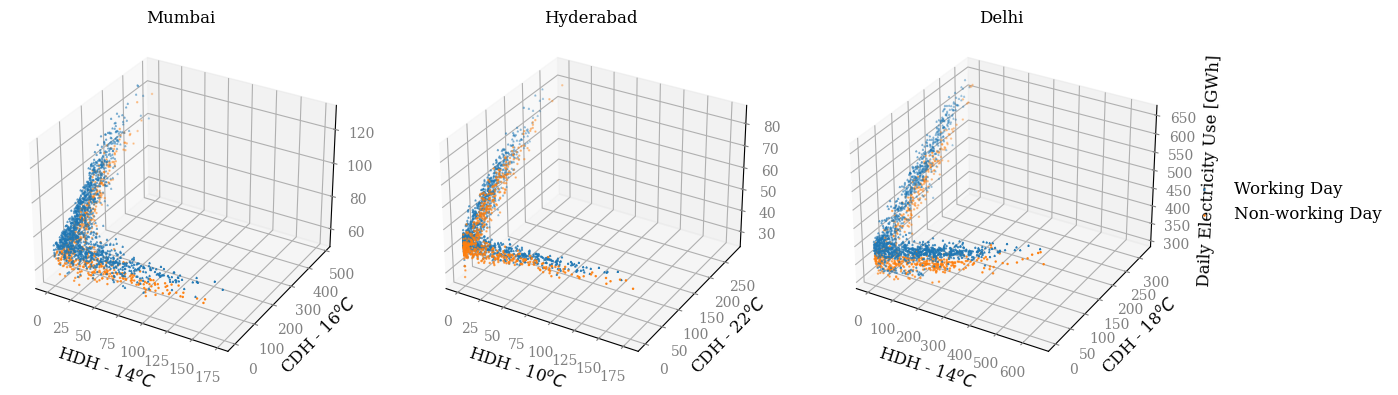

In [21]:
hcdh_result.index.names = ['City', 'Day Type']

data_all = [mum, hyd, delhi]
cities_shortName = ['mum', 'hyd', 'delhi']
heatBaseTemps = hcdh_result.loc[hcdh_result.index.get_level_values('Day Type')=='WD']['Heating Base Temp'].values
coolBaseTemps = hcdh_result.loc[hcdh_result.index.get_level_values('Day Type')=='WD']['Cooling Base Temp'].values

fig = plt.figure(figsize=(15,4))

for index in range(3):
    ax = fig.add_subplot(1, 3, index+1, projection='3d')
    city = cities[index]
    city_shortName = cities_shortName[index]
    data = data_all[index]
    
    heatBaseTemp, coolBaseTemp = heatBaseTemps[index], coolBaseTemps[index]
    
    data_wd = data[data['Day Type']=='Working Day']
    data_nwd = data[data['Day Type']=='Non-Working Day']
    ax.scatter(data_wd[f'HDH_{heatBaseTemp}'], data_wd[f'CDH_{coolBaseTemp}'],
                  data_wd['Electricity demand, daily sum, (GWh)'], 
                  marker='^', s=0.6, label='Working Day')
    ax.scatter(data_nwd[f'HDH_{heatBaseTemp}'], data_nwd[f'CDH_{coolBaseTemp}'],
                  data_nwd['Electricity demand, daily sum, (GWh)'], 
                  marker='o', s=0.6, label='Non-working Day')
    ax.set_xlabel(f'HDH - {heatBaseTemp}$^oC$')
    ax.set_ylabel(f'CDH - {coolBaseTemp}$^oC$')
    ax.set_title(city)

    
    data['HCDH'] = data[f'HDH_{heatBaseTemp}']+data[f'CDH_{coolBaseTemp}']
    data = data[['Electricity demand, daily sum, (GWh)', 'HCDH']]
    data.to_csv(generate_result_data_path(f'{city_shortName}_prophet'))
    
ax.set_zlabel('Daily Electricity Use [GWh]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.gcf().subplots_adjust(bottom=-0.55)
plt.savefig(generate_fig_path('Figure 11'))

## Making prediction for model comparison

In [22]:
data_all = [mum, hyd, delhi]
cities_shortName = ['mum', 'hyd', 'delhi']
heatBaseTemps = hcdh_result.loc[hcdh_result.index.get_level_values('Day Type')=='WD']['Heating Base Temp'].values
coolBaseTemps = hcdh_result.loc[hcdh_result.index.get_level_values('Day Type')=='WD']['Cooling Base Temp'].values

In [23]:
for index in range(3):
    data = data_all[index].copy()
    data = data[['Electricity demand, daily sum, (GWh)','Temperature, daily mean (degC)',
                 f'HDH_{heatBaseTemps[index]}',f'CDH_{coolBaseTemps[index]}','Day Type']]
    data.rename(columns={'Electricity demand, daily sum, (GWh)': 'y',
                         'Temperature, daily mean (degC)':'temp',
                         f'HDH_{heatBaseTemps[index]}':'HDH',
                         f'CDH_{coolBaseTemps[index]}':'CDH'}, inplace=True)
    data_train, data_test = utlis.prepare_data(data, train_ratio=0.75)
    data['train'] = False
    data.loc[data_train.index,'train'] = True

    data_train_wd = data_train[data_train['Day Type'] == 'Working Day']
    data_train_nwd = data_train[data_train['Day Type'] == 'Non-Working Day']
    data_wd = data[data['Day Type'] == 'Working Day']
    data_nwd = data[data['Day Type'] == 'Non-Working Day']

    ## HCDH model
    model_wd = LinearRegression()
    X_wd = data_train_wd[['HDH','CDH']].values
    y_wd = data_train_wd['y'].values
    model_wd.fit(X_wd,y_wd)
    data_wd['yhat_hcdh'] = model_wd.predict(data_wd[['HDH','CDH']].values)

    ## 5p model
    model_wd = InverseModel(data_train_wd['temp'].values, data_train_wd['y'].values, 'y')
    model_wd.fit_model()
    data_wd['yhat_5p'] = model_wd.piecewise_linear(data_wd['temp'].values, *model_wd.p)

    linear_predict = pd.concat([data_wd,data_nwd]).sort_index()
    linear_predict.index = pd.to_datetime(linear_predict['ds'])

    linear_predict.to_csv(generate_result_data_path(f'predict/linear_{cities_shortName[index]}'), index=False)

C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\3448375452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wd['yhat_hcdh'] = model_wd.predict(data_wd[['HDH','CDH']].values)
C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\3448375452.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_wd['yhat_5p'] = model_wd.piecewise_linear(data_wd['temp'].values, *model_wd.p)
C:\Users\kushs\AppData\Local\Temp\ipykernel_11792\3448375452.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop